# Model Engineering

In [28]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
import xgboost
import mlxtend
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, validation_curve, LearningCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score, jaccard_score, f1_score, auc
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


from mlxtend.classifier import StackingCVClassifier, Adaline
from mlxtend.plotting import plot_learning_curves, plot_decision_regions
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from xgboost import XGBClassifier
from xgboost import plot_importance


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set default plotting style and set all parematers as standard ready to publish plots
def set_plotting_style():
    # Set the default style
    sns.set_style("darkgrid")

    # Set the default context with font scale
    sns.set_context("paper",
                    font_scale=1.3, rc={"lines.linewidth": 1.0})

    # Set the default color palette
    sns.set_palette("plasma")

    # Set the default figure size
    plt.rcParams['figure.figsize'] = [10, 6]

# Call the function to set the default plotting style
set_plotting_style()

## Data Prep for Machine Learning

In [3]:
# Load the train set
churn_train = pd.read_csv(r"C:/Users/HP/Desktop/Customer Churn Prediction/Data/Processed/churn_train.csv")

# Load the test set
churn_test = pd.read_csv(r"C:/Users/HP/Desktop/Customer Churn Prediction/Data/Processed/churn_test.csv")

In [4]:
# Separate features from target
X = churn_train.drop('churn', axis=1)
y = churn_train['churn']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
# Store the column names before transformation
column_names = X_train.columns

# Now you can refer to 'column_names' whenever you need the original column names

In [6]:
from sklearn.compose import ColumnTransformer

# Store the column names before transformation
column_names = X_train.columns

# Select numerical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Create a column transformer which will standardize only the numerical columns
ct = ColumnTransformer([
    ('scale', StandardScaler(), numerical_cols)
], remainder='passthrough')

# Fit the transformer to the training data
ct.fit(X_train)

# Transform the training and validation data
X_train = ct.transform(X_train)
X_val = ct.transform(X_val)

# Assuming 'churn' is your target variable
X_test = churn_test.drop('churn', axis=1)
y_test = churn_test['churn']

# Transform the test data
X_test = ct.transform(X_test)

In [8]:
from imblearn import over_sampling
ros = over_sampling.RandomOverSampler(random_state=42)

# Fit and apply the transform
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

## Model Training

### 1. Support Vector Machines

In [22]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Create a new SVC
svc = SVC()

# Create a new GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='f1', return_train_score=True)

# Fit the GridSearchCV to the data
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             return_train_score=True, scoring='f1')

In [23]:
# Get the best parameters
best_params = grid_search.best_params_

# Create a new SVC with the best parameters
svc_best = SVC(**best_params)

# Train the SVC on the resampled data
svc_best.fit(X_resampled, y_resampled)

SVC(C=1, gamma=1)

In [24]:
grid_search.best_score_

0.9991724137931033

In [25]:
# Predict the target variable for the validation data
y_pred_svc = svc_best.predict(X_val)

# Compute the F1 score for the predictions
f1_score_svc = f1_score(y_val, y_pred_svc)

print("SVC F1 score: ", f1_score_svc)

SVC F1 score:  0.0


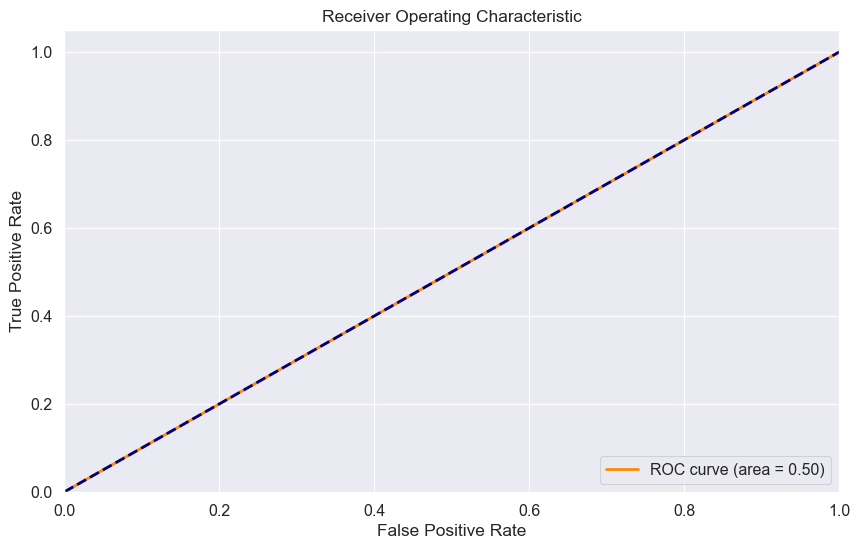

In [29]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_svc)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [30]:
# Get classification report
print(classification_report(y_val, y_pred_svc))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       456
           1       0.00      0.00      0.00        78

    accuracy                           0.85       534
   macro avg       0.43      0.50      0.46       534
weighted avg       0.73      0.85      0.79       534



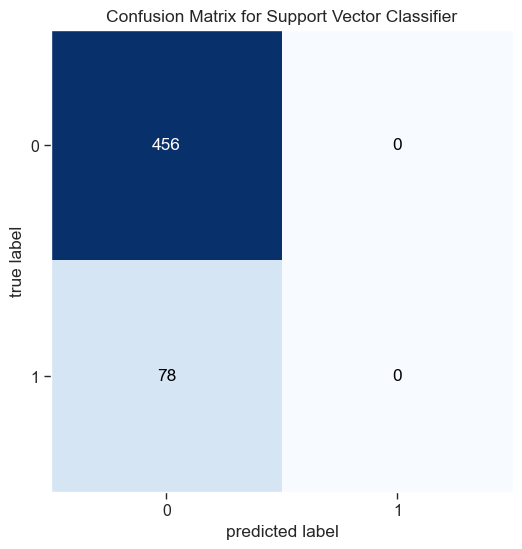

In [49]:
# Plot the confusion matrix
plot_confusion_matrix(confusion_matrix(y_val, y_pred_svc))

plt.title('Confusion Matrix for Support Vector Classifier')
plt.show()

### 2. Logistic Regression

In [33]:
# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Create a new Logistic Regression
log_reg = LogisticRegression()

# Create a new GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1')

# Fit the GridSearchCV to the data
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='f1')

In [34]:
# Get the best parameters
best_params = grid_search.best_params_

# Create a new Logistic Regression with the best parameters
log_reg_best = LogisticRegression(**best_params)

# Train the Logistic Regression on the resampled data
log_reg_best.fit(X_resampled, y_resampled)

LogisticRegression(C=0.01, penalty='l1', solver='liblinear')

In [35]:
# Predict the target variable for the validation data
y_pred_log_reg = log_reg_best.predict(X_val)

# Compute the F1 score for the predictions
f1_score_log_reg = f1_score(y_val, y_pred_log_reg)

print("Logistic Regression F1 score: ", f1_score_log_reg)

Logistic Regression F1 score:  0.42741935483870963


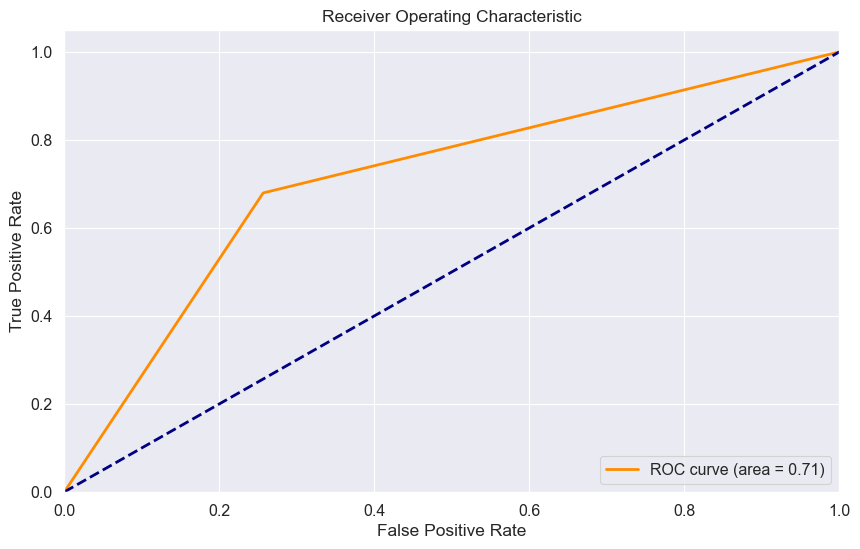

In [36]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_log_reg)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [37]:
from sklearn.metrics import classification_report

# Generate a classification report for the Logistic Regression model
report = classification_report(y_val, y_pred_log_reg)

print("Classification Report for Logistic Regression: \n", report)

Classification Report for Logistic Regression: 
               precision    recall  f1-score   support

           0       0.93      0.74      0.83       456
           1       0.31      0.68      0.43        78

    accuracy                           0.73       534
   macro avg       0.62      0.71      0.63       534
weighted avg       0.84      0.73      0.77       534



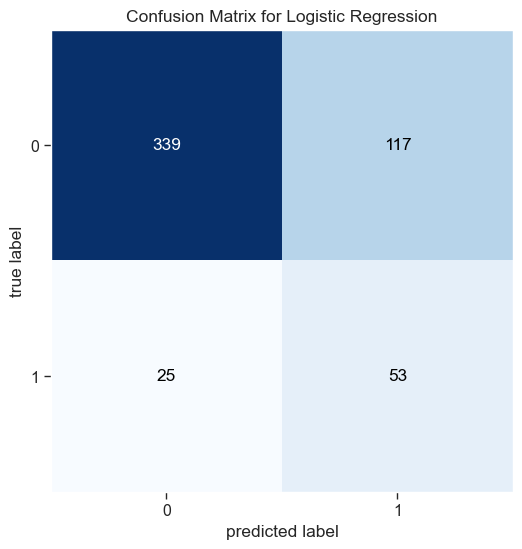

In [48]:
# Plot the confusion matrix for the Logistic Regression model
# Plot the confusion matrix
plot_confusion_matrix(confusion_matrix(y_val, y_pred_log_reg))

plt.title('Confusion Matrix for Logistic Regression')
plt.show()

### 4. Decision Trees

In [41]:
# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# Create a Decision Tree classifier
dt = DecisionTreeClassifier()

# Create the grid search object
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='f1')

# Fit the grid search object to the data
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1')

In [42]:
# Get the best parameters
best_params = grid_search.best_params_

# Create a new Decision Tree with the best parameters
dt_best = DecisionTreeClassifier(**best_params)

# Train the Decision Tree on the resampled data
dt_best.fit(X_resampled, y_resampled)

DecisionTreeClassifier(criterion='entropy')

In [43]:
# Predict the target variable for the validation data
y_pred_dt = dt_best.predict(X_val)

# Compute the F1 score for the predictions
f1_score_dt = f1_score(y_val, y_pred_dt)

print("Decision Tree F1 score: ", f1_score_dt)

Decision Tree F1 score:  0.6753246753246753


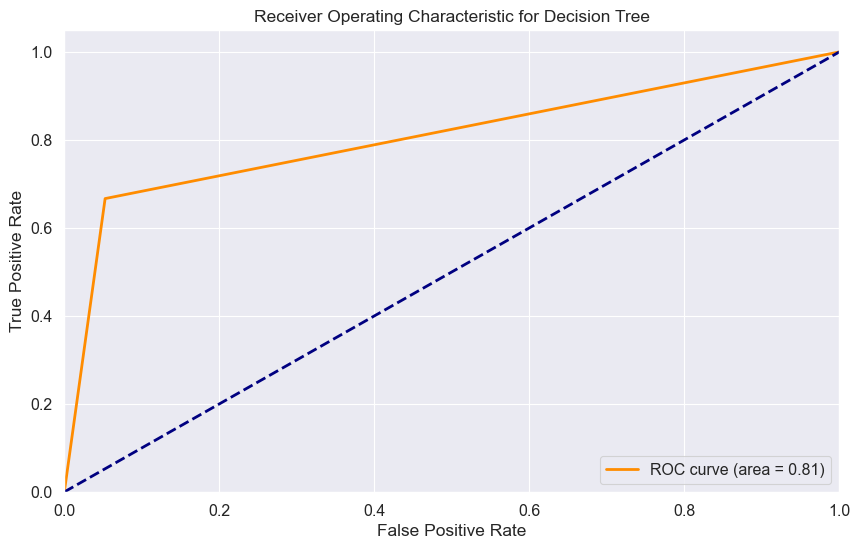

In [44]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_dt)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Decision Tree')
plt.legend(loc="lower right")
plt.show()

In [45]:
# Generate a classification report for the Decision Tree model
report = classification_report(y_val, y_pred_dt)

print("Classification Report for Decision Tree: \n", report)

Classification Report for Decision Tree: 
               precision    recall  f1-score   support

           0       0.94      0.95      0.95       456
           1       0.68      0.67      0.68        78

    accuracy                           0.91       534
   macro avg       0.81      0.81      0.81       534
weighted avg       0.91      0.91      0.91       534



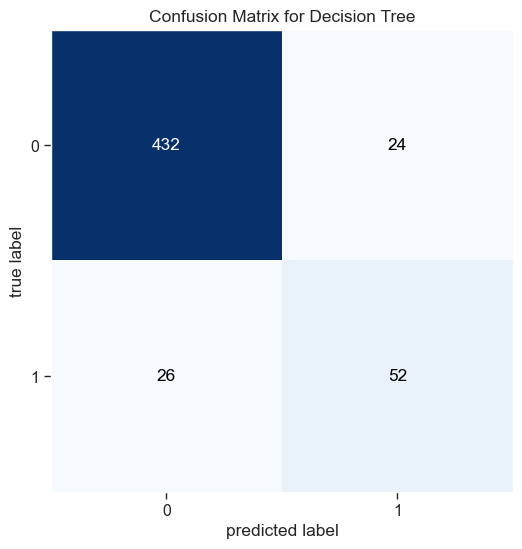

In [47]:
# Plot the confusion matrix for the Decision Tree model
plot_confusion_matrix(confusion_matrix(y_val, y_pred_dt))

plt.title('Confusion Matrix for Decision Tree')
plt.show()

### 4. Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Create the grid search object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1')

# Fit the grid search object to the data
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1')

In [53]:
from sklearn.ensemble import RandomForestClassifier

# Get the best parameters
best_params = grid_search.best_params_

# Create a new Random Forest with the best parameters
rf_best = RandomForestClassifier(**best_params)

# Train the Random Forest on the resampled data
rf_best.fit(X_resampled, y_resampled)

RandomForestClassifier(criterion='entropy')

In [54]:
# Predict the target variable for the validation data
y_pred_rf = rf_best.predict(X_val)

# Compute the F1 score for the predictions
f1_score_rf = f1_score(y_val, y_pred_rf)

print("Random Forest F1 score: ", f1_score_rf)

Random Forest F1 score:  0.8142857142857143


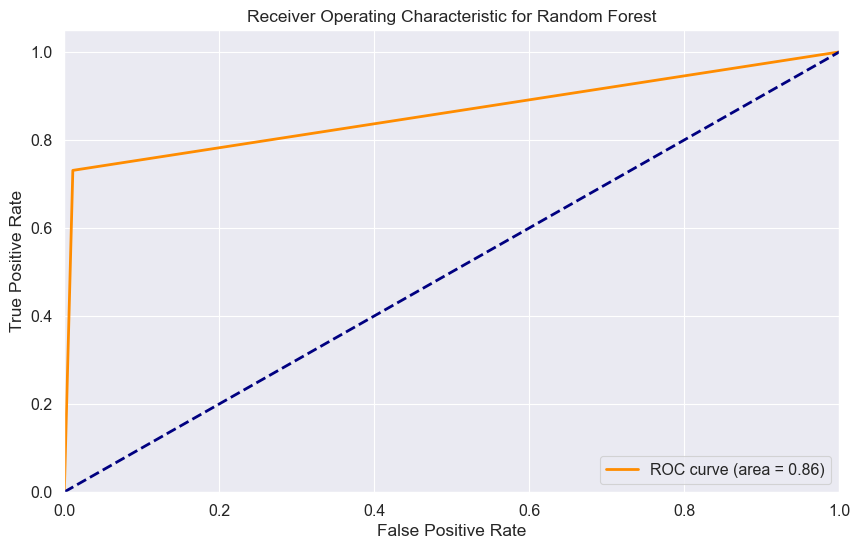

In [55]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_rf)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Random Forest')
plt.legend(loc="lower right")
plt.show()

In [56]:
# Generate a classification report for the Random Forest model
report = classification_report(y_val, y_pred_rf)

print("Classification Report for Random Forest: \n", report)

Classification Report for Random Forest: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       456
           1       0.92      0.73      0.81        78

    accuracy                           0.95       534
   macro avg       0.94      0.86      0.89       534
weighted avg       0.95      0.95      0.95       534



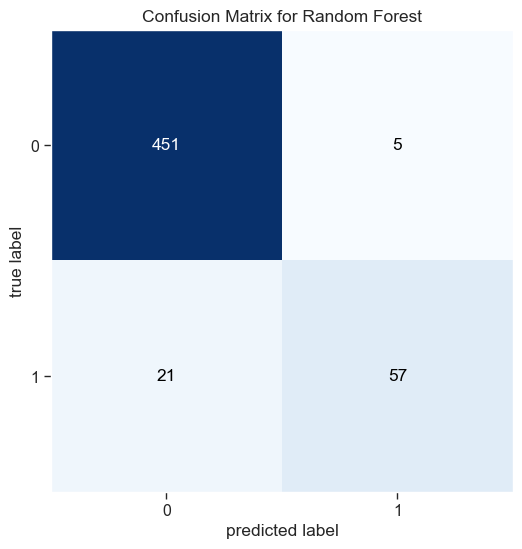

In [57]:
# Plot the confusion matrix for the Random Forest model
plot_confusion_matrix(confusion_matrix(y_val, y_pred_rf))

plt.title('Confusion Matrix for Random Forest')
plt.show()

### 5. Adaptive Linear Neuron

In [70]:
ada = Adaline(epochs=500, 
              eta=0.001, 
              minibatches=500, # for SGD learning w. minibatch size 20
              random_seed=1,
              print_progress=3)

ada.fit(X_resampled, y_resampled)
# plot_decision_regions(X_resampled, np.array(y_resampled), clf=ada, filler_feature_values={2: 0, 3: 0})
# plt.title('Adaline - Stochastic Gradient Descent w. Minibatches')
# plt.show()

Iteration: 1/500 | Cost 1241.93 | Elapsed: 00:00:00 | ETA: 00:00:00

Iteration: 500/500 | Cost 1242.58 | Elapsed: 0:00:22 | ETA: 0:00:00

In [71]:
ada.score(X_val, y_val)

0.7528089887640449

In [72]:
# Predict the target variable for the validation data
y_pred_ada = ada.predict(X_val)

# Compute the F1 score for the predictions
f1_score_ada = f1_score(y_val, y_pred_ada)

print("Adaline F1 score: ", f1_score_ada)

Adaline F1 score:  0.4210526315789474


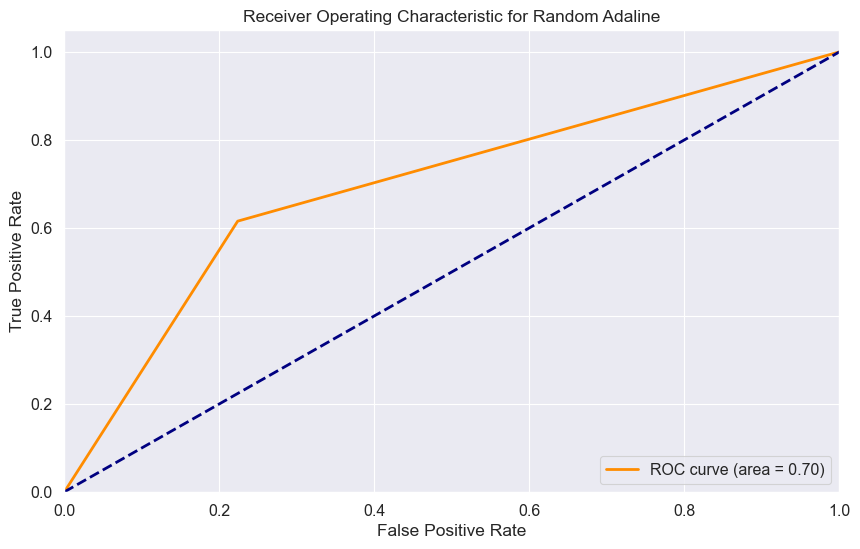

In [73]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_ada)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Random Adaline')
plt.legend(loc="lower right")
plt.show()

In [74]:
# Generate a classification report for the Adaline model
report = classification_report(y_val, y_pred_ada)

print("Classification Report for Adaline: \n", report)

Classification Report for Adaline: 
               precision    recall  f1-score   support

           0       0.92      0.78      0.84       456
           1       0.32      0.62      0.42        78

    accuracy                           0.75       534
   macro avg       0.62      0.70      0.63       534
weighted avg       0.83      0.75      0.78       534



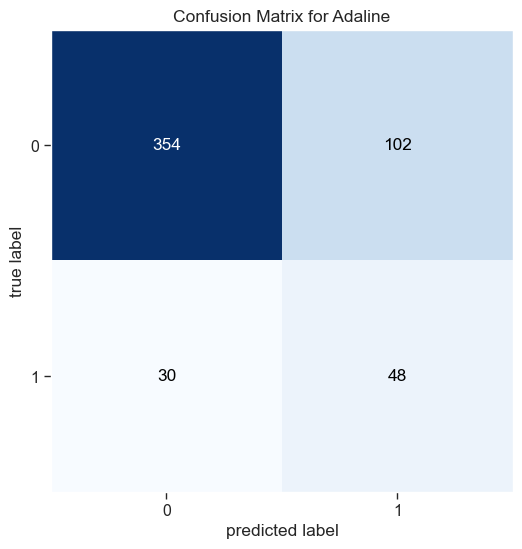

In [75]:
# Plot the confusion matrix for the Adaline model
plot_confusion_matrix(confusion_matrix(y_val, y_pred_ada))

plt.title('Confusion Matrix for Adaline')
plt.show()

### 6. SGD Classifier

In [76]:
from sklearn.linear_model import SGDClassifier

# Define the parameter grid
param_grid = {
    'loss': ['perceptron'],  # perceptron is the linear loss used by Adaline
    'eta0': [0.1, 0.01, 0.001],  # learning rate
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'penalty': [None, 'l2', 'l1', 'elasticnet'],  # regularization
    'max_iter': [1000, 5000, 10000]  # number of passes over the training data (aka epochs)
}

# Create an Adaline classifier
adaline = SGDClassifier()

# Create the grid search object
grid_search = GridSearchCV(estimator=adaline, param_grid=param_grid, cv=5, scoring='f1')

# Fit the grid search object to the data
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=SGDClassifier(),
             param_grid={'eta0': [0.1, 0.01, 0.001],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'loss': ['perceptron'],
                         'max_iter': [1000, 5000, 10000],
                         'penalty': [None, 'l2', 'l1', 'elasticnet']},
             scoring='f1')

In [77]:
from sklearn.linear_model import SGDClassifier

# Get the best parameters
best_params = grid_search.best_params_

# Create a new SGDClassifier with the best parameters
sgd_best = SGDClassifier(**best_params)

# Train the SGDClassifier on the resampled data
sgd_best.fit(X_resampled, y_resampled)

SGDClassifier(eta0=0.001, learning_rate='constant', loss='perceptron',
              penalty='elasticnet')

In [78]:
# Predict the target variable for the validation data
y_pred_sgd = sgd_best.predict(X_val)

# Compute the F1 score for the predictions
f1_score_sgd = f1_score(y_val, y_pred_sgd)

print("SGDClassifier F1 score: ", f1_score_sgd)

SGDClassifier F1 score:  0.3167701863354037


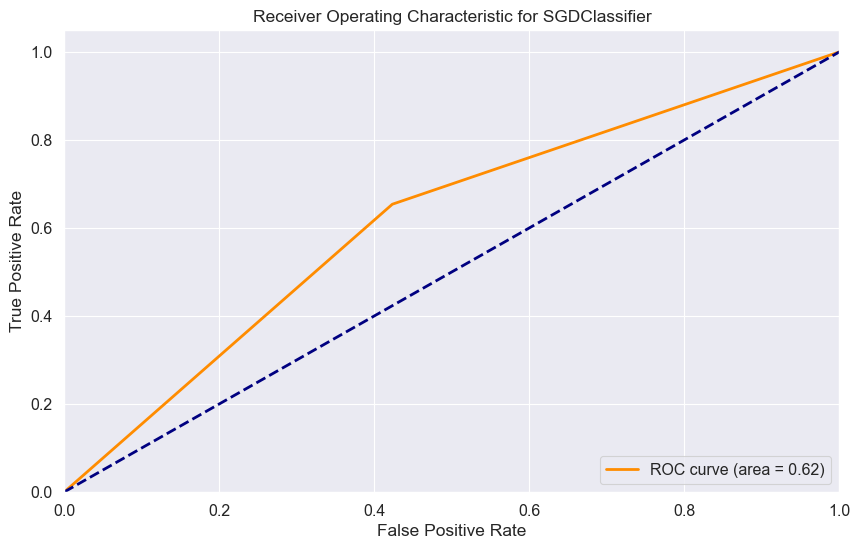

In [79]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_sgd)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for SGDClassifier')
plt.legend(loc="lower right")
plt.show()

In [80]:
# Generate a classification report for the SGDClassifier model
report = classification_report(y_val, y_pred_sgd)

print("Classification Report for SGDClassifier: \n", report)

Classification Report for SGDClassifier: 
               precision    recall  f1-score   support

           0       0.91      0.58      0.71       456
           1       0.21      0.65      0.32        78

    accuracy                           0.59       534
   macro avg       0.56      0.62      0.51       534
weighted avg       0.80      0.59      0.65       534



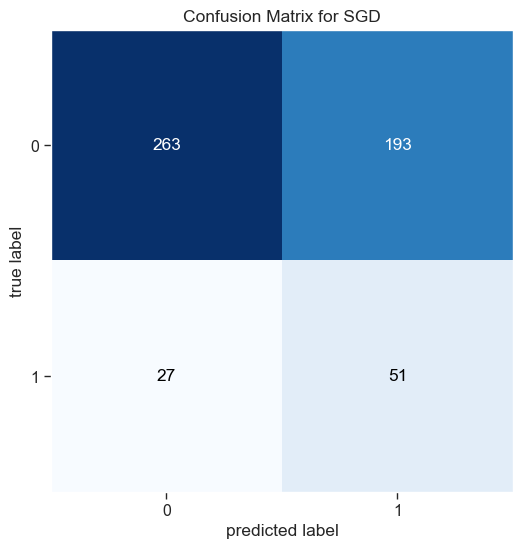

In [81]:
# Plot the confusion matrix for the SGD model
plot_confusion_matrix(confusion_matrix(y_val, y_pred_sgd))

plt.title('Confusion Matrix for SGD')
plt.show()

### 7. AdaBoost

In [82]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # number of weak learners to train iteratively
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 1],  # it contributes to the weights of weak learners
    'algorithm': ['SAMME', 'SAMME.R']  # boosting algorithm
}

# Create an AdaBoost classifier
adaboost = AdaBoostClassifier()

# Create the grid search object
grid_search = GridSearchCV(estimator=adaboost, param_grid=param_grid, cv=5, scoring='f1')

# Fit the grid search object to the data
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.01, 0.05, 0.1, 0.3, 1],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='f1')

In [83]:
# Get the best parameters
best_params = grid_search.best_params_

# Create a new AdaBoostClassifier with the best parameters
adaboost_best = AdaBoostClassifier(**best_params)

# Train the AdaBoostClassifier on the resampled data
adaboost_best.fit(X_resampled, y_resampled)

AdaBoostClassifier(learning_rate=1, n_estimators=200)

In [84]:
# Predict the target variable for the validation data
y_pred_adaboost = adaboost_best.predict(X_val)

# Compute the F1 score for the predictions
f1_score_adaboost = f1_score(y_val, y_pred_adaboost)

print("AdaBoostClassifier F1 score: ", f1_score_adaboost)

AdaBoostClassifier F1 score:  0.49


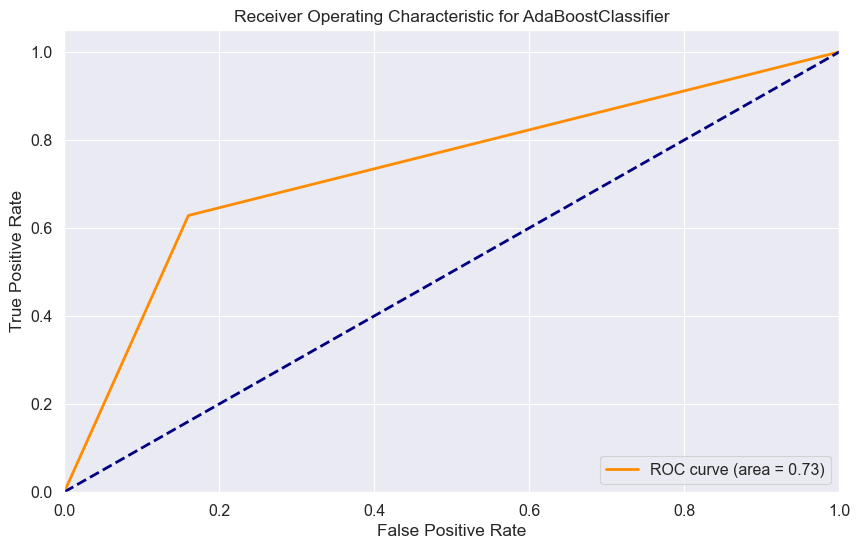

In [85]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_adaboost)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for AdaBoostClassifier')
plt.legend(loc="lower right")
plt.show()

In [86]:
# Generate a classification report for the AdaBoostClassifier model
report = classification_report(y_val, y_pred_adaboost)

print("Classification Report for AdaBoostClassifier: \n", report)

Classification Report for AdaBoostClassifier: 
               precision    recall  f1-score   support

           0       0.93      0.84      0.88       456
           1       0.40      0.63      0.49        78

    accuracy                           0.81       534
   macro avg       0.67      0.73      0.69       534
weighted avg       0.85      0.81      0.83       534



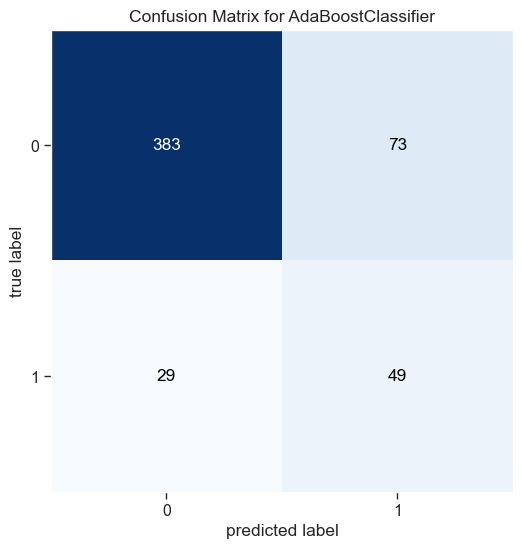

In [87]:
# Plot the confusion matrix for the AdaBoostClassifier model
plot_confusion_matrix(confusion_matrix(y_val, y_pred_adaboost))

plt.title('Confusion Matrix for AdaBoostClassifier')
plt.show()

In [89]:
# Calculate the misclassification error in percentage
misclassification_error = (1 - accuracy_score(y_val, y_pred_adaboost)) * 100

print("Misclassification error for AdaBoostClassifier: ", misclassification_error, "%")

Misclassification error for AdaBoostClassifier:  19.10112359550562 %


### 8. Gradient Boosting Classifier

In [92]:
from sklearn.ensemble import GradientBoostingClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # number of boosting stages to perform
    'learning_rate': [0.01, 0.1, 0.2],  # shrinks the contribution of each tree
    'max_depth': [3, 4, 5]  # maximum depth of the individual regression estimators
}

# Create a GradientBoostingClassifier
gradient_boosting = GradientBoostingClassifier()

# Create the grid search object
grid_search = GridSearchCV(estimator=gradient_boosting, param_grid=param_grid, cv=5, scoring='f1')

# Fit the grid search object to the data
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [93]:
# Get the best parameters
best_params = grid_search.best_params_

# Create a new GradientBoostingClassifier with the best parameters
gradient_boosting_best = GradientBoostingClassifier(**best_params)

# Train the GradientBoostingClassifier on the resampled data
gradient_boosting_best.fit(X_resampled, y_resampled)

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, n_estimators=300)

In [94]:
# Predict the target variable for the validation data
y_pred_gradient_boosting = gradient_boosting_best.predict(X_val)

# Compute the F1 score for the predictions
f1_score_gradient_boosting = f1_score(y_val, y_pred_gradient_boosting)

print("GradientBoostingClassifier F1 score: ", f1_score_gradient_boosting)

GradientBoostingClassifier F1 score:  0.8309859154929576


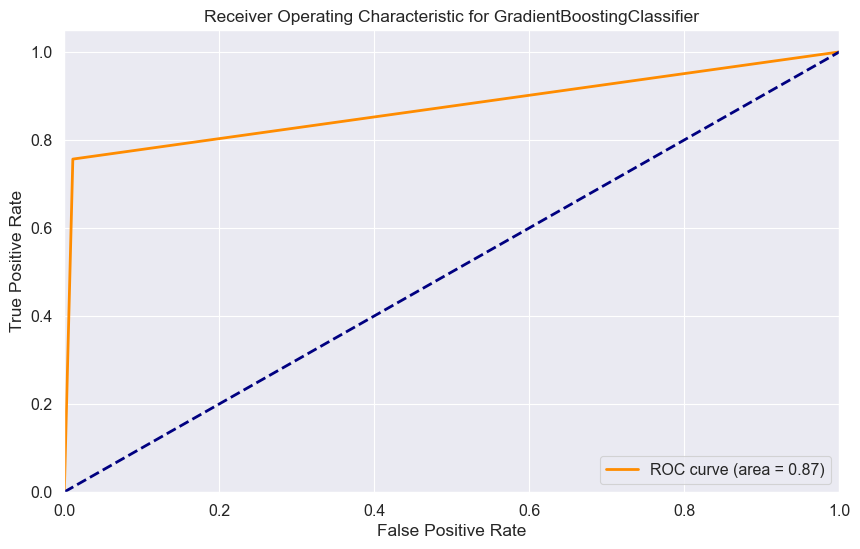

In [95]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_gradient_boosting)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for GradientBoostingClassifier')
plt.legend(loc="lower right")
plt.show()

In [96]:
# Generate a classification report for the GradientBoostingClassifier model
report = classification_report(y_val, y_pred_gradient_boosting)

print("Classification Report for GradientBoostingClassifier: \n", report)

Classification Report for GradientBoostingClassifier: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       456
           1       0.92      0.76      0.83        78

    accuracy                           0.96       534
   macro avg       0.94      0.87      0.90       534
weighted avg       0.95      0.96      0.95       534



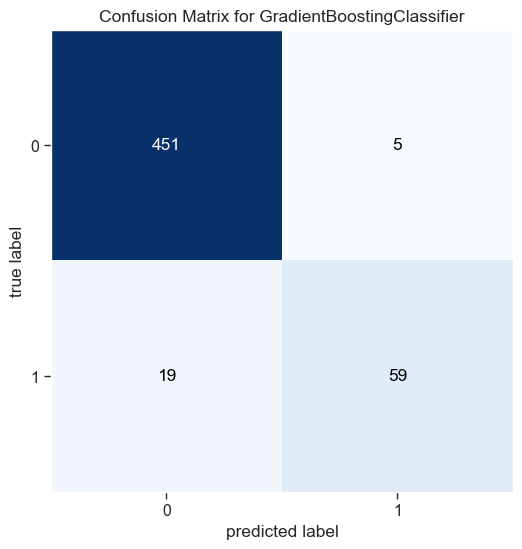

In [97]:
# Plot the confusion matrix for the AdaBoostClassifier model
plot_confusion_matrix(confusion_matrix(y_val, y_pred_gradient_boosting))

plt.title('Confusion Matrix for GradientBoostingClassifier')
plt.show()

### 9. XGBoost

In [98]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # number of boosted trees to fit
    'learning_rate': [0.01, 0.1, 0.2],  # step size shrinkage used in update to prevents overfitting
    'max_depth': [3, 4, 5],  # maximum depth of a tree
    'subsample': [0.5, 0.7, 1.0],  # subsample ratio of the training instances
    'colsample_bytree': [0.5, 0.7, 1.0]  # subsample ratio of columns when constructing each tree
}

# Create an XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create the grid search object
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='f1')

# Fit the grid search object to the data
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     m...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.7, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.5, 0.7, 1.0]},
             scoring='f1')

In [99]:
# Get the best parameters
best_params = grid_search.best_params_

# Create a new XGBClassifier with the best parameters
xgb_best = XGBClassifier(use_label_encoder=False, eval_metric='logloss', **best_params)

# Train the XGBClassifier on the resampled data
xgb_best.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [100]:
# Predict the target variable for the validation data
y_pred_xgb = xgb_best.predict(X_val)

# Compute the F1 score for the predictions
f1_score_xgb = f1_score(y_val, y_pred_xgb)

print("XGBoost F1 score: ", f1_score_xgb)

XGBoost F1 score:  0.8226950354609929


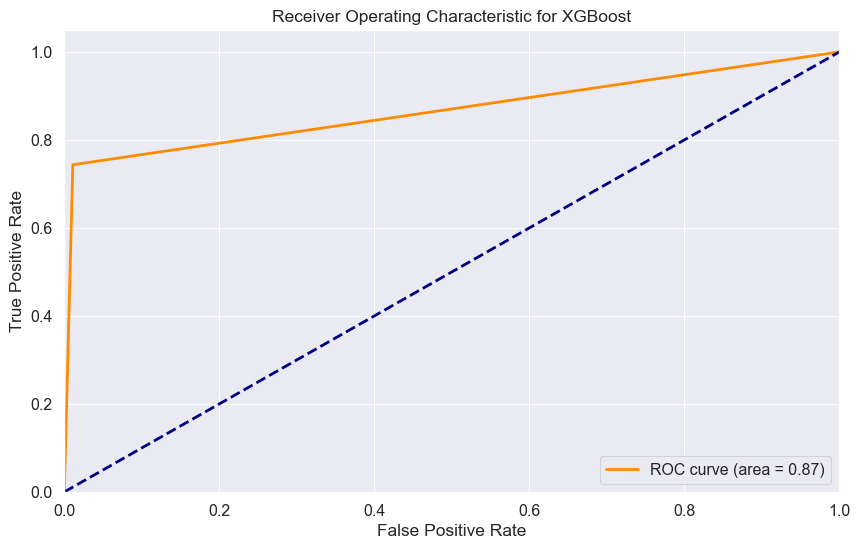

In [101]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_xgb)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for XGBoost')
plt.legend(loc="lower right")
plt.show()

In [102]:
# Generate a classification report for the XGBoost model
report = classification_report(y_val, y_pred_xgb)

print("Classification Report for XGBoost: \n", report)

Classification Report for XGBoost: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       456
           1       0.92      0.74      0.82        78

    accuracy                           0.95       534
   macro avg       0.94      0.87      0.90       534
weighted avg       0.95      0.95      0.95       534



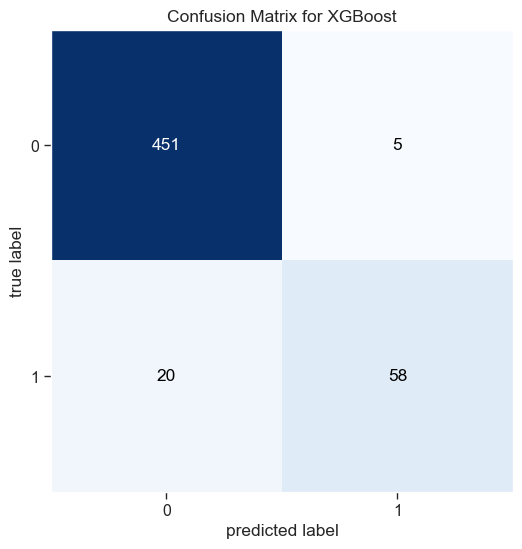

In [103]:
# Plot the confusion matrix for the AdaBoostClassifier model
plot_confusion_matrix(confusion_matrix(y_val, y_pred_xgb))

plt.title('Confusion Matrix for XGBoost')
plt.show()

### 10. LightGBM

In [106]:
%pip install lightgbm

                                              0.0/1.3 MB ? eta -:--:--
                                              0.0/1.3 MB ? eta -:--:--
                                              0.0/1.3 MB ? eta -:--:--
                                              0.0/1.3 MB ? eta -:--:--
                                              0.0/1.3 MB ? eta -:--:--
                                              0.0/1.3 MB ? eta -:--:--
                                              0.0/1.3 MB ? eta -:--:--
                                              0.0/1.3 MB ? eta -:--:--
                                              0.0/1.3 MB ? eta -:--:--
                                              0.0/1.3 MB ? eta -:--:--
                                              0.0/1.3 MB ? eta -:--:--
                                              0.0/1.3 MB ? eta -:--:--
                                              0.0/1.3 MB ? eta -:--:--
                                              0.0/1.3 MB ? eta -:--:--
      

In [112]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # number of boosted trees to fit
    'learning_rate': [0.01, 0.1, 0.2],  # step size shrinkage used in update to prevents overfitting
    'max_depth': [3, 4, 5],  # maximum depth of a tree
    'subsample': [0.5, 0.7, 1.0], # subsample ratio of the training instances
    'num_leaves': [7, 15, 31, 63]
}

# Create a LGBMClassifier
lgbm = LGBMClassifier(verbose=-1)

# Create the grid search object
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, scoring='f1')

# Fit the grid search object to the data
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=LGBMClassifier(verbose=-1),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [7, 15, 31, 63],
                         'subsample': [0.5, 0.7, 1.0]},
             scoring='f1')

In [113]:
from lightgbm import LGBMClassifier

# Get the best parameters
best_params = grid_search.best_params_

# Create a new LGBMClassifier with the best parameters
lgbm_best = LGBMClassifier(**best_params)

# Train the LGBMClassifier on the resampled data
lgbm_best.fit(X_resampled, y_resampled)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1822, number of negative: 1822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2380
[LightGBM] [Info] Number of data points in the train set: 3644, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

LGBMClassifier(learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.5)

In [114]:
# Predict the target variable for the validation data
y_pred_lgbm = lgbm_best.predict(X_val)

# Compute the F1 score for the predictions
f1_score_lgbm = f1_score(y_val, y_pred_lgbm)

print("LightGBM F1 score: ", f1_score_lgbm)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
LightGBM F1 score:  0.8175182481751825


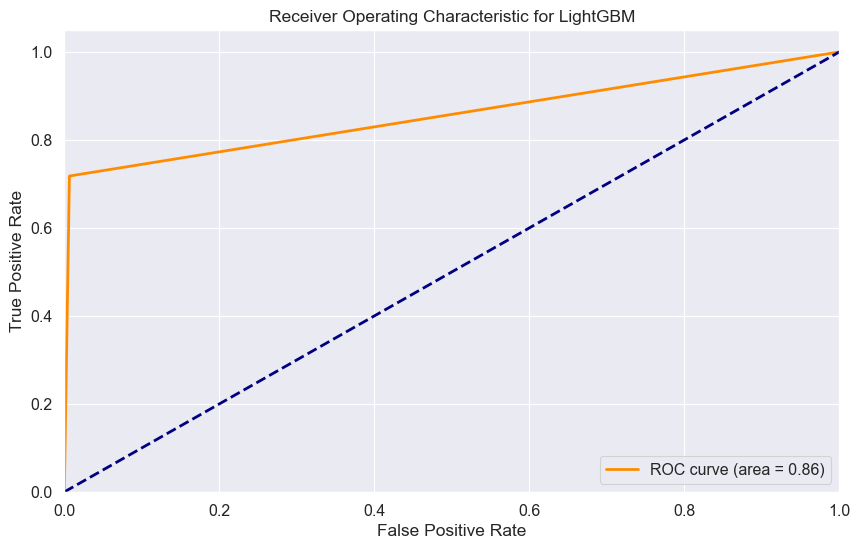

In [115]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_lgbm)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for LightGBM')
plt.legend(loc="lower right")
plt.show()

In [116]:
from sklearn.metrics import classification_report

# Generate a classification report for the LightGBM model
report = classification_report(y_val, y_pred_lgbm)

print("Classification Report for LightGBM: \n", report)

Classification Report for LightGBM: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       456
           1       0.95      0.72      0.82        78

    accuracy                           0.95       534
   macro avg       0.95      0.86      0.90       534
weighted avg       0.95      0.95      0.95       534



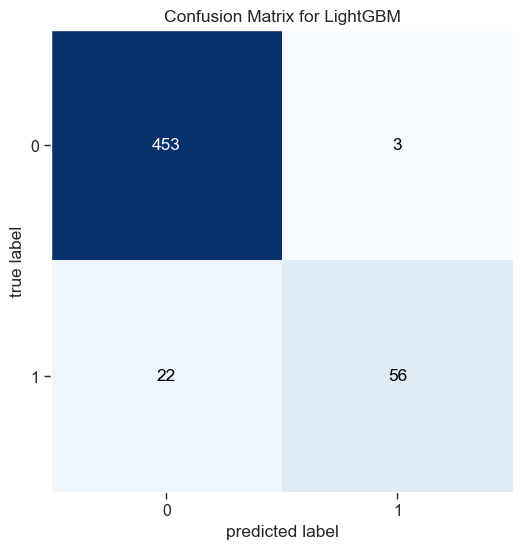

In [117]:
# Plot the confusion matrix for the LightGBM model
plot_confusion_matrix(confusion_matrix(y_val, y_pred_lgbm))

plt.title('Confusion Matrix for LightGBM')
plt.show()

### 11. KNN

In [118]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # number of neighbors to use
    'weights': ['uniform', 'distance'],  # weight function used in prediction
    'metric': ['euclidean', 'manhattan']  # distance metric used for the tree
}

# Create a KNeighborsClassifier
knn = KNeighborsClassifier()

# Create the grid search object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='f1')

# Fit the grid search object to the data
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [119]:
# Get the best parameters
best_params = grid_search.best_params_

# Create a new KNeighborsClassifier with the best parameters
knn_best = KNeighborsClassifier(**best_params)

# Train the KNeighborsClassifier on the resampled data
knn_best.fit(X_resampled, y_resampled)

KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')

In [120]:
# Predict the target variable for the validation data
y_pred_knn = knn_best.predict(X_val)

# Compute the F1 score for the predictions
f1_score_knn = f1_score(y_val, y_pred_knn)

print("KNN F1 score: ", f1_score_knn)

KNN F1 score:  0.509090909090909


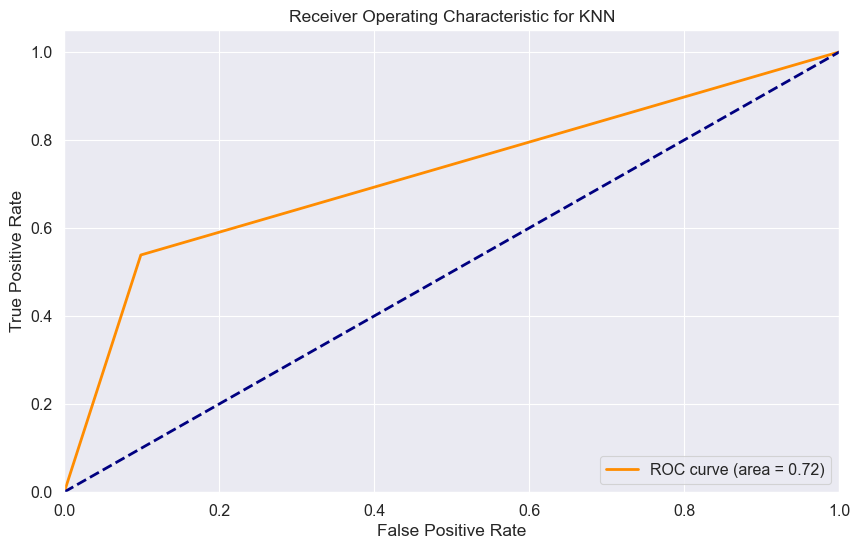

In [121]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_knn)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for KNN')
plt.legend(loc="lower right")
plt.show()

In [122]:
# Generate a classification report for the KNN model
report = classification_report(y_val, y_pred_knn)

print("Classification Report for KNN: \n", report)

Classification Report for KNN: 
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       456
           1       0.48      0.54      0.51        78

    accuracy                           0.85       534
   macro avg       0.70      0.72      0.71       534
weighted avg       0.86      0.85      0.85       534



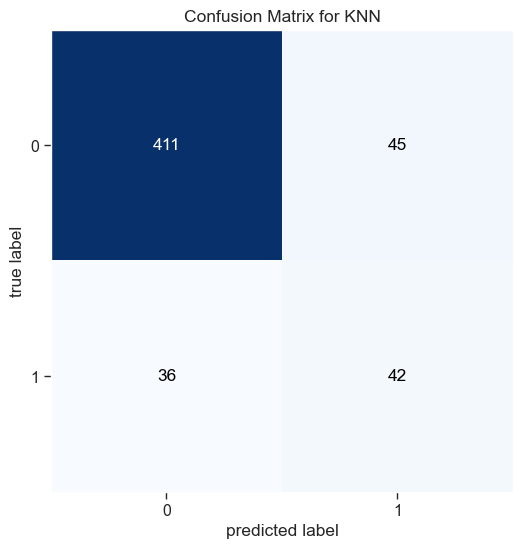

In [124]:
# Plot the confusion matrix for the KNN model
plot_confusion_matrix(confusion_matrix(y_val, y_pred_knn))

plt.title('Confusion Matrix for KNN')
plt.show()

## Test Set (Out of Sample Performance)

In [140]:
# List of models
models = ['SVC',
          'Logistic Regression',
          'Decision Tree', 
          'Random Forest',
          'LightGBM', 
          'XGBoost', 
          'KNN', 
          'Gradient Boosting',
          'AdaBoost',
          'SGD',
          'Adaline']

# List of predictions
predictions = [y_pred_svc, 
               y_pred_log_reg, 
               y_pred_dt, 
               y_pred_rf, 
               y_pred_lgbm, 
               y_pred_xgb, 
               y_pred_knn,
               y_pred_gradient_boosting,
               y_pred_adaboost,
               y_pred_sgd,
               y_pred_ada]

# Initialize lists to store performance metrics
f1_scores = []
roc_auc_scores = []

# Compute performance metrics for each model
for pred in predictions:
    f1_scores.append(f1_score(y_val, pred))
    roc_auc_scores.append(roc_auc_score(y_val, pred))

# Create a DataFrame
df1 = pd.DataFrame({
    'Model': models,
    'F1 Score (Val)': f1_scores,
    'ROC AUC Score (Val)': roc_auc_scores
})

# Round the values to 2 decimal places
df1 = df1.round(2)

# Sort the DataFrame by 'F1 Score' and 'ROC AUC Score' in descending order
df_sorted = df1.sort_values(by=['F1 Score (Val)', 'ROC AUC Score (Val)'], ascending=False).reset_index(drop=True)

# Print the sorted DataFrame
df_sorted


,Model,F1 Score (Val),ROC AUC Score (Val)
0,Gradient Boosting,0.83,0.87
1,XGBoost,0.82,0.87
2,LightGBM,0.82,0.86
3,Random Forest,0.81,0.86
4,Decision Tree,0.68,0.81
5,KNN,0.51,0.72
6,AdaBoost,0.49,0.73
7,Logistic Regression,0.43,0.71
8,Adaline,0.42,0.70
9,SGD,0.32,0.62


In [141]:
# List of models
models = ['SVC',
          'Logistic Regression',
          'Decision Tree', 
          'Random Forest',
          'LightGBM', 
          'XGBoost', 
          'KNN', 
          'Gradient Boosting',
          'AdaBoost',
          'SGD',
          'Adaline']

# List of models
model_objects = [svc_best, 
                 log_reg_best, 
                 dt_best, 
                 rf_best, 
                 lgbm_best, 
                 xgb_best, 
                 knn_best, 
                 gradient_boosting_best, 
                 adaboost_best, 
                 sgd_best, 
                 adaboost_best]

# Initialize lists to store test set performances 
f1_scores_test = []
roc_auc_scores_test = []

# Make predictions and compute performances for each model
for model in model_objects:
    # Make predictions on the test set
    y_pred_test = model.predict(X_test)
    
    # Compute the F1 score and ROC AUC score
    f1_score_test = f1_score(y_test, y_pred_test)
    roc_auc_score_test = roc_auc_score(y_test, y_pred_test)
    
    # Add the scores to the lists
    f1_scores_test.append(f1_score_test)
    roc_auc_scores_test.append(roc_auc_score_test)
    
# Create a DataFrame
df = pd.DataFrame({
    'Model': models,
    'F1 Score (Test)': f1_scores_test,
    'ROC AUC Score (Test)': roc_auc_scores_test
})

# Round the values to 2 decimal places
df = df.round(2)

# Print the DataFrame
df

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,Model,F1 Score (Test),ROC AUC Score (Test)
0,SVC,0.00,0.50
1,Logistic Regression,0.49,0.78
2,Decision Tree,0.73,0.84
3,Random Forest,0.82,0.87
4,LightGBM,0.79,0.85
5,XGBoost,0.82,0.88
6,KNN,0.50,0.74
7,Gradient Boosting,0.83,0.87
8,AdaBoost,0.58,0.80
9,SGD,0.31,0.62


In [142]:
# Merge df1 and df based on the 'Model' column
merged_df = df1.merge(df, on='Model', how='inner')

# Print the merged DataFrame
merged_df

,Model,F1 Score (Val),ROC AUC Score (Val),F1 Score (Test),ROC AUC Score (Test)
0,SVC,0.00,0.50,0.00,0.50
1,Logistic Regression,0.43,0.71,0.49,0.78
2,Decision Tree,0.68,0.81,0.73,0.84
3,Random Forest,0.81,0.86,0.82,0.87
4,LightGBM,0.82,0.86,0.79,0.85
5,XGBoost,0.82,0.87,0.82,0.88
6,KNN,0.51,0.72,0.50,0.74
7,Gradient Boosting,0.83,0.87,0.83,0.87
8,AdaBoost,0.49,0.73,0.58,0.80
9,SGD,0.32,0.62,0.31,0.62


In [143]:
# F1 Score Variance
merged_df['F1 Score Variance'] = merged_df['F1 Score (Val)'] - merged_df['F1 Score (Test)']

# AUC Score Variance
merged_df['ROC AUC Score Variance'] = merged_df['ROC AUC Score (Val)'] - merged_df['ROC AUC Score (Test)']

In [144]:
merged_df

,Model,F1 Score (Val),ROC AUC Score (Val),F1 Score (Test),ROC AUC Score (Test),F1 Score Variance,ROC AUC Score Variance
0,SVC,0.00,0.50,0.00,0.50,0.00,0.00
1,Logistic Regression,0.43,0.71,0.49,0.78,-0.06,-0.07
2,Decision Tree,0.68,0.81,0.73,0.84,-0.05,-0.03
3,Random Forest,0.81,0.86,0.82,0.87,-0.01,-0.01
4,LightGBM,0.82,0.86,0.79,0.85,0.03,0.01
5,XGBoost,0.82,0.87,0.82,0.88,0.00,-0.01
6,KNN,0.51,0.72,0.50,0.74,0.01,-0.02
7,Gradient Boosting,0.83,0.87,0.83,0.87,0.00,0.00
8,AdaBoost,0.49,0.73,0.58,0.80,-0.09,-0.07
9,SGD,0.32,0.62,0.31,0.62,0.01,0.00


In [147]:
# Rearrange the columns

# List of columns
columns_order = ['Model', 
           'F1 Score (Val)', 
           'F1 Score (Test)', 
           'F1 Score Variance', 
           'ROC AUC Score (Val)', 
           'ROC AUC Score (Test)', 
           'ROC AUC Score Variance']

# Rearrange the columns
merged_df = merged_df.reindex(columns=columns_order)

# Display the dataframe
merged_df

,Model,F1 Score (Val),F1 Score (Test),F1 Score Variance,ROC AUC Score (Val),ROC AUC Score (Test),ROC AUC Score Variance
0,SVC,0.00,0.00,0.00,0.50,0.50,0.00
1,Logistic Regression,0.43,0.49,-0.06,0.71,0.78,-0.07
2,Decision Tree,0.68,0.73,-0.05,0.81,0.84,-0.03
3,Random Forest,0.81,0.82,-0.01,0.86,0.87,-0.01
4,LightGBM,0.82,0.79,0.03,0.86,0.85,0.01
5,XGBoost,0.82,0.82,0.00,0.87,0.88,-0.01
6,KNN,0.51,0.50,0.01,0.72,0.74,-0.02
7,Gradient Boosting,0.83,0.83,0.00,0.87,0.87,0.00
8,AdaBoost,0.49,0.58,-0.09,0.73,0.80,-0.07
9,SGD,0.32,0.31,0.01,0.62,0.62,0.00


In [148]:
# Sort the DataFrame by 'F1 Score' and 'ROC AUC Score' in descending order
merged_df_sorted = merged_df.sort_values(by=['F1 Score (Test)', 'ROC AUC Score (Test)'], ascending=False).reset_index(drop=True)

# Print the sorted DataFrame
merged_df_sorted

,Model,F1 Score (Val),F1 Score (Test),F1 Score Variance,ROC AUC Score (Val),ROC AUC Score (Test),ROC AUC Score Variance
0,Gradient Boosting,0.83,0.83,0.00,0.87,0.87,0.00
1,XGBoost,0.82,0.82,0.00,0.87,0.88,-0.01
2,Random Forest,0.81,0.82,-0.01,0.86,0.87,-0.01
3,LightGBM,0.82,0.79,0.03,0.86,0.85,0.01
4,Decision Tree,0.68,0.73,-0.05,0.81,0.84,-0.03
5,AdaBoost,0.49,0.58,-0.09,0.73,0.80,-0.07
6,Adaline,0.42,0.58,-0.16,0.70,0.80,-0.10
7,KNN,0.51,0.50,0.01,0.72,0.74,-0.02
8,Logistic Regression,0.43,0.49,-0.06,0.71,0.78,-0.07
9,SGD,0.32,0.31,0.01,0.62,0.62,0.00


The best performing model is `Gradient Boosting Classifier`. It had a variance of 0.00 on both the F1 and AUC Scores while also registering the highest F1 and AUC Scores closely followed by `XGBoost Classifier`

## Model Interpretation

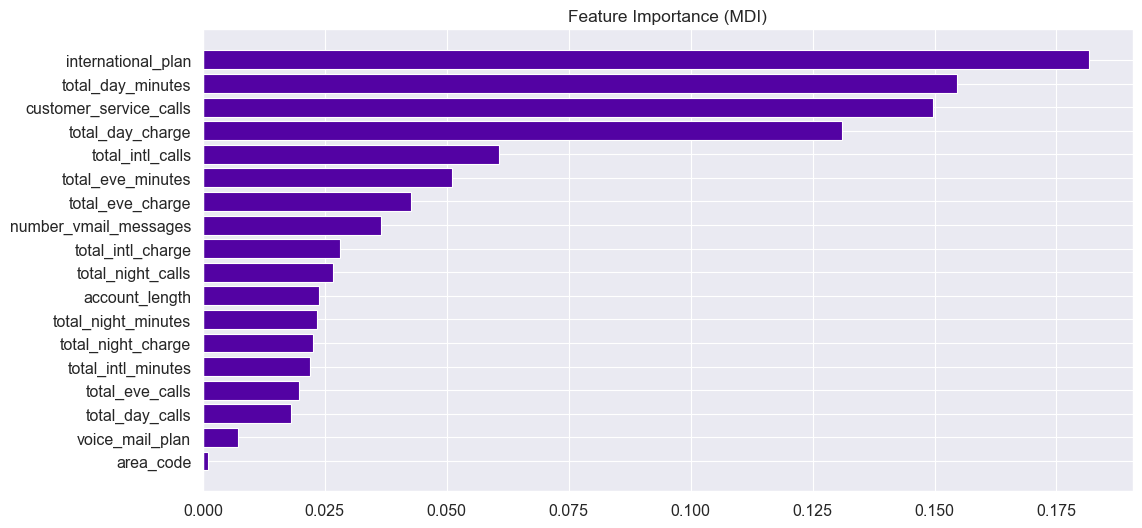

In [150]:
# Feature importance plot using gradient descent classifier
plt.rcParams['figure.figsize'] = [12, 8]

feature_importance = gradient_boosting_best.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(column_names)[sorted_idx])
plt.title('Feature Importance (MDI)')
plt.show()